# 1. Data Analysis

## Data analysis intro

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

### Data analysis

- What is data
- What is data analysis

### Unsupervised learning

To gain a deeper understanding of a particular dataset it is often a good strategy to analyse it using unsupervised methods.

Unsupervised learning is a machine learning technique used to cluster, detect, reduce data without the need for the data to be labeled. That means the data can be a raw input, no one needs 

### The curse of dimensionality

- Problems with high dimension data.
- Relate to MNIST.
- Describe the curse of dimensionality.

### Dimensionality reduction

Dimensionality reduction allows you to map a high dimension space into a lower dimension space. Principle component analysis does this by calculating the vector which maximise the variance in the data. This is the principle component and the next most varied is orthogonal to this and so on.

- What is dimensionality reduction
- The aim of dimensionality reduction.
- Main approaches:
  - Projection
  - Manifold
- Common methods:
  - PCA
  - t-SNE
  - Autoencoding
  - ??

### MNIST

We shall download and take an inital look at the MNIST dataset

In [2]:
X, y = fetch_openml('mnist_784', return_X_y=True)

Create a NumPy array and analyse the shape of the data:

In [3]:
X = np.array(X).astype('int')
y = np.array(y).astype('int')

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Image shape: {X[0].shape}")

X shape: (70000, 784), y shape: (70000,)
Image shape: (784,)


From the shape we can see that we have the full MNIST dataset of 70000 hand written didgets. 

They are yet to be split into a training and testing set and each image has been flattened to a (784,) array rather than the standard (28,28) form.

We will need to create a train, validation and test set before we proceed using SKlearns `train_test_split`.

In [4]:
# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# remove a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [5]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(70000, 784)
(44800, 784)
(11200, 784)
(14000, 784)


Now we can train the data and analyse using the validation set before testing on the test set. This will allow us to minimise overfitting by ensuring our model generalises well.

Later on we shall use cross-validation on the entire training set to ensure maximum generalisation, but for now we shall use the the validation set for this.

## 1.1 Principle Component Analysis

### PCA

We shall fit the training data using PCA:

- What is PCA?
  - Idea
  - Algorithm

### Dimensionality reduction with PCA

We shall fit the training data to a PCA model.

In [6]:
pca = PCA()
pca.fit(X_train)

PCA()

Now we can look at the principle components using the `components_` attribute:

In [7]:
print(pca.components_)
pca.components_.shape

[[-2.04267565e-19 -2.77555756e-17 -5.55111512e-17 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 5.50021256e-19 -5.55111512e-17  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.28830536e-19 -1.11022302e-16  5.55111512e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-0.00000000e+00 -4.18200390e-02  1.02422921e-01 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  1.55334980e-01  7.80944800e-02 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  1.06708855e-02  1.49348950e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


(784, 784)

This has calculated a principle component for each of the features in the dataset (784)

#### Variance ratio

We can see how much each component contributes to the overall variance in the data using the `explained_variance_ratio_` attribute:

In [8]:
explained_var_ratio = pca.explained_variance_ratio_
print(explained_var_ratio[:20], "...")

[0.0973537  0.07176998 0.06156933 0.05403095 0.04902501 0.04306446
 0.03269544 0.02884161 0.02769847 0.02345112 0.02100843 0.02040217
 0.01703607 0.01692874 0.01576743 0.01477665 0.01325563 0.01275005
 0.01186625 0.01161131] ...


Due to the large number of features it is hard to make sense of the data, but they have been ordered from most varied to least. 

We shall extract the first 10 components and see how much they contribute to the data's variance:

In [9]:
top_var = explained_var_ratio[:10]
print(top_var)
print(f"Variance for top 10 principle components: {top_var.sum():2f}")

[0.0973537  0.07176998 0.06156933 0.05403095 0.04902501 0.04306446
 0.03269544 0.02884161 0.02769847 0.02345112]
Variance for top 10 principle components: 0.489500


We can see the top 10 principle components contribute to almost half of the variance across all the features.

We shall now plot the cumulative sum of adding each principle component:

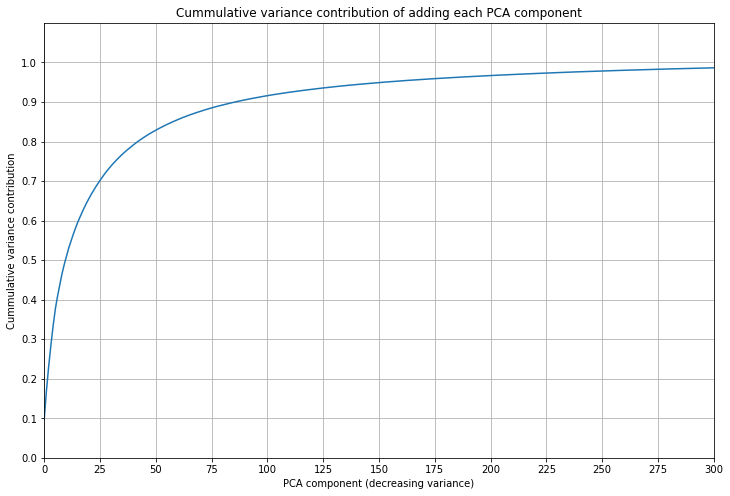

In [10]:
cumsum_var_ratio = np.cumsum(explained_var_ratio)
xs = np.arange(len(cumsum_var_ratio))

# beautify this!
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Cummulative variance contribution of adding each PCA component")
ax.set_xlabel("PCA component (decreasing variance)")
ax.set_ylabel("Cummulative variance contribution")
ax.grid()
ax.set_xticks(np.arange(0, len(cumsum_var_ratio), 25))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(xmin=0, xmax=300)
ax.set_ylim(ymin=0, ymax=1.1)
ax.plot(xs, cumsum_var_ratio)
plt.show()

Here only the first 300 components have been plotted to get a clearer view of the components with the most variance.

As discussed earlier the first 10 components contribute to around 50% of the variance, this increases to 70% with 25 components and starts leveling off with around 25 components.

Depending on accuracy vs. minimusing components around 25-75 components should be enough to retain data whilst minimising dimenionality.

#### Reconstucting from reduced dimensions

We shall try to reconstruct some MNIST images using only a subset of the principle components:

In [11]:
pca_50 = PCA(n_components=50)
deconstructed_50 = pca_50.fit_transform(X_train)
reconstructed_50 = pca_50.inverse_transform(deconstructed_50)
reconstructed_50.shape

(44800, 784)

We can create a function to compare n images to their reconstructions as follows:

In [12]:
def plot_reconstructed(plot_imgs, plot_reconstructed_imgs, num=5):
    fig = plt.figure(figsize=(12, 10))
    idx = 1
    # get random indices
    indices = np.random.choice(len(plot_imgs), num)
    # show (num) test iamges
    for i, ind in enumerate(indices):
        ax = fig.add_subplot(1+len(plot_reconstructed_imgs), num, idx)
        ax.get_xaxis().set_visible(False)
        if i == 0:
            ax.set_ylabel("original", fontsize=14)
            ax.set_yticks([])
        else:
            ax.get_yaxis().set_visible(False)
        ax.imshow(plot_imgs[ind], cmap='gray')
        idx += 1
    # show (num) reconstructed images
    for j, (name, reconstructed_imgs) in enumerate(plot_reconstructed_imgs):
        for i, ind in enumerate(indices):
            ax = fig.add_subplot(1+len(plot_reconstructed_imgs), num, idx)
            ax.get_xaxis().set_visible(False)
            if i == 0:
                ax.set_ylabel("{} components".format(name), fontsize=14)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            ax.imshow(reconstructed_imgs[ind], cmap='gray')
            idx += 1
    plt.tight_layout()

In [13]:
# imgs = X_train.reshape(-1, 28, 28)
# reconstructed_imgs = reconstructed_50.reshape(-1, 28, 28)

# print("50 Components (~85% variance):")
# plot_reconstructed(imgs, reconstructed_imgs)

The patterns in the data have been retained well. This is not too suprising given the simplicity of the data - this might not be the case for larger images.

Let's see what happens when we reduce the number of components further:

In [14]:
def pca_reduce_img(X, n):
    pca = PCA(n_components=n)
    deconstructed = pca.fit_transform(X)
    reconstructed = pca.inverse_transform(deconstructed)
    return reconstructed.reshape(-1, 28, 28)


reconstructed_100 = pca_reduce_img(X_train, 100)
reconstructed_25 = pca_reduce_img(X_train, 25)
reconstructed_5 = pca_reduce_img(X_train, 5)

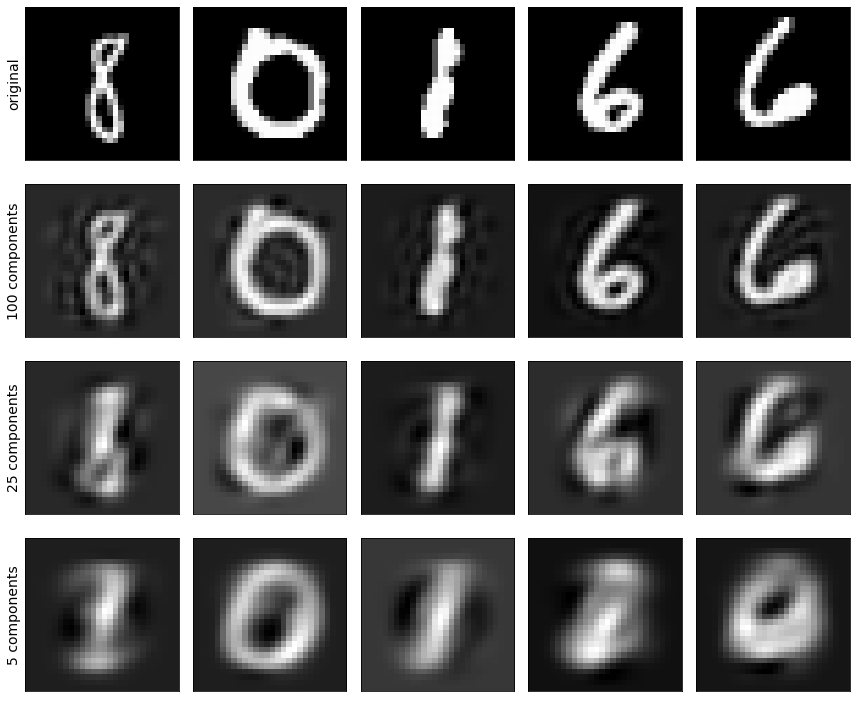

In [15]:
imgs = np.reshape(X_train, (-1, 28, 28))

plot_reconstructed(imgs, [("100", reconstructed_100), ("25", reconstructed_25), ("5", reconstructed_5)])

Reconstructing with 25 components still produces reasonably clear images, but this still maintains 70% of the variance so this is not suprising. What is superising is that reconstructing with only 3% the number of features as before produces good results.

Reducing further to 10 and 5 components results in images which have most of their original information and are not easily recognisable. This does not nescasarily mean a classifier would do a bad job on them though.

### Other PCA methods

- Different types of PCA
  - Normal / linear
  - Probablistic
  - Random
  - Incremental
  - Kernel
    - Various kernels

### Visualisation with PCA

Reducing further does have an important use though; visualisation! Reducing down to 2 features means we can visualise the data easily so let's do that:

In [12]:
pca_2 = PCA(n_components=2)
X_train_2 = pca_2.fit_transform(X_train)

X_train_2.shape

(44800, 2)

As expected we now have the training set reduced to just 2 dimensions. 

We can use this to visualise the MNIST dataset and see how PCA has maximised the variance:

In [17]:
def plt_2d_mnist(X, y, title):
    xs, ys = X[:, 0], X[:, 1]
    c = np.array(y).astype('int')
    fix, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(title)
    ax.scatter(xs, ys, c=c, cmap="tab10", s=1, alpha=0.5)
    plt.show()

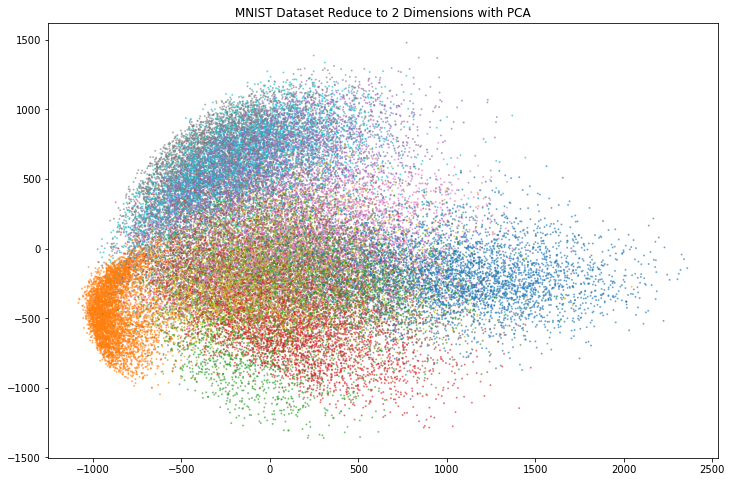

In [18]:
plt_2d_mnist(X_train_2, y_train, "MNIST Dataset Reduce to 2 Dimensions with PCA")

Looking at the scatter plot we can see some separability between the classes, but it is still difficult to see any obvious boundaries between them.

We shall attempt to split the data using ICA.

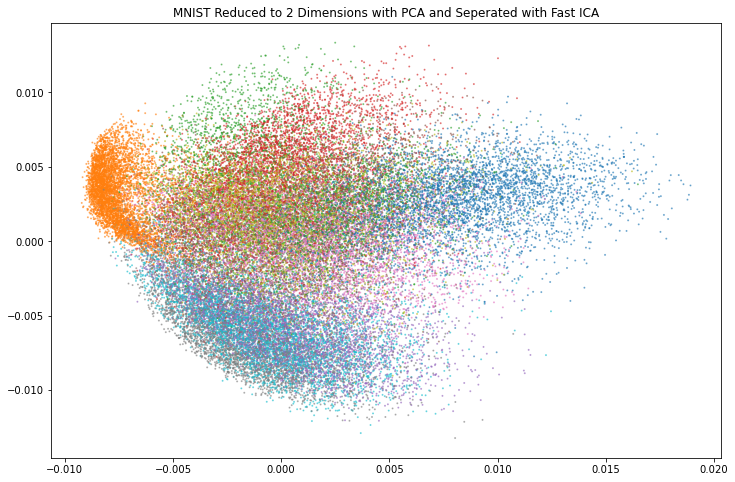

In [19]:
fica = FastICA(n_components=2, max_iter=1000)
X_fica_2 = fica.fit_transform(X_train_2)

plt_2d_mnist(X_fica_2, y_train, "MNIST Reduced to 2 Dimensions with PCA and Seperated with Fast ICA")

As the data is seemingly non separable we should try using a kernel. This will map the data into higher dimensional space before performing dimensionality reduction allowing for a complex non linear projections into lower dimensional space.

We shall try the radial basis function (RBF) kernel:

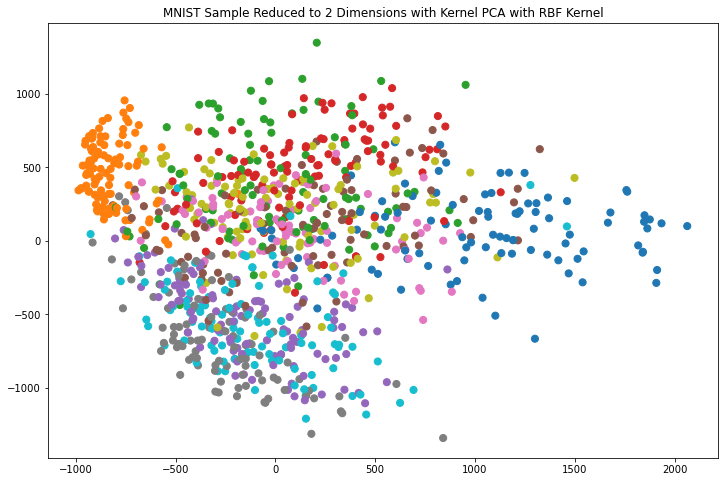

In [20]:
rbf_pca = KernelPCA(n_components=2, kernel='linear')

samples = np.random.choice(len(X_train), 1000)
Xsamples = X_train[samples]
ysamples = y_train[samples]
samples_reduced = rbf_pca.fit_transform(Xsamples)

xs, ys = samples_reduced[:, 0], samples_reduced[:, 1]
c = np.array(ysamples).astype('int')
fix, ax = plt.subplots(figsize=(12, 8))
ax.set_title("MNIST Sample Reduced to 2 Dimensions with Kernel PCA with RBF Kernel")
ax.scatter(xs, ys, c=c, cmap="tab10", s=50, alpha=1)
plt.show()

KernelPCA uses a lot of memory and so I was unable to fit the entire dataset. Applying it to 100 random samples let's us see how it would have performed should the whole dataset have worked. We can see there is not really much more seperability than the 'linear' PCA so continuing samples would not give better results.

#### Other dimensionality reduction methods for visualisation

A better method for visualising high dimension data is t-distributed stochastic neighbor embedding (TSNE). We shall use PCA to reduce the dimensionality of the data to 20 features and then use TSNE to reduce further down to 2 features for visualisation.

In [21]:
pca_20 = PCA(n_components=20)
X_train_20 = pca_20.fit_transform(X_train)

In [22]:
tsne = TSNE()
X_train_tsne_2 = tsne.fit_transform(X_train_20)

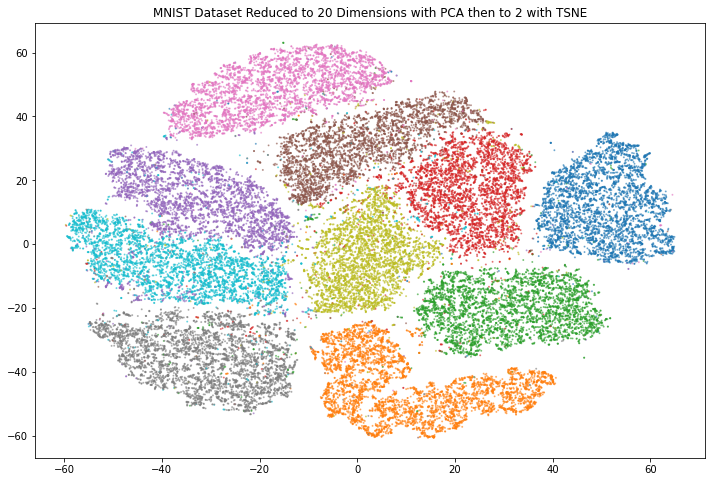

In [23]:
plt_2d_mnist(X_train_tsne_2, y_train, "MNIST Dataset Reduced to 20 Dimensions with PCA then to 2 with TSNE")

This has worked a lot better in separating the different classes. Although it is still not perfect, it has managed to cluster the classes quite well.

The general way t-SNE works is by reducing dimensionality whilst keeping similar instances close and moving differing instances away from eachother.

## 1.2 Clustering

## Clustering

- What is clustering?
- Applications
- Different approaches
  - KMeans
  - Gaussian mixtures

### K-Means

K-Means is a method of clustering which attempts to cluster the given data into K classes. It works by setting K random points as the cluster centroids, then assigning each of the data points to their nearest cluster. The centroid locations are then updated to that of the mean of their assigned data points positions. The datapoints are then reassigned to their closest and the centroids updated again. This repeats until convergence (no movement between repeats).

### Clustering and visualising MNIST

In [13]:
scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_train_2)

We shall apply kmeans to the first two principle components found earlier with PCA to get the centroid locations.

In [14]:
kmeans = KMeans(n_clusters=10, n_init=100)
kmeans.fit(scaled_X)

# centroids = kmeans.cluster_centers_
print(kmeans.cluster_centers_)

[[-1.45678992 -1.0106187 ]
 [ 0.10790267  0.08140978]
 [ 0.5125146  -1.56166731]
 [ 0.18035746  1.67680189]
 [ 1.05938125  0.62378136]
 [ 0.96568949 -0.5244099 ]
 [-0.60657477  1.0422322 ]
 [-0.95923365 -0.04813417]
 [-0.26187691 -0.81486647]
 [ 2.28572889 -0.43149795]]


Now we have our 10 centroid locations, we can plot them on the earlier visualisation and see where they fall.

In [15]:
def plot_veronoi(X, y, kmeans):
    """
    Plot veronoi diagram with data given KMeans centroids
    """
    xs, ys = X[:, 0], X[:, 1]
    x_min, x_max = xs.min()-0.05, xs.max()+0.05
    y_min, y_max = ys.min()-0.05, ys.max()+0.05
    c = np.array(y).astype('int')
    centroids = kmeans.cluster_centers_
    # generate veronoi boundaries for plotting
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # extended pastelmap
    pastel1 = plt.cm.Pastel1(np.linspace(0, 1, 128))
    pastel2 = plt.cm.Pastel2(np.linspace(0, 1, 128))
    pastels = np.vstack((pastel1, pastel2))
    pastelmap = mcolors.LinearSegmentedColormap.from_list('pastels', pastels)
    # plot veronoi
    plt.figure(figsize=(12, 8))
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=pastelmap,
               aspect='auto',
               origin='lower')
#     plt.contour(Z, extent=(x_min, x_max, y_min, y_max), linewidths=1, colors='grey')
    # plot data and centroids
    plt.scatter(xs, ys, s=1, alpha=0.1, c="black")
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black',
                s=50, linewidths=2, zorder=10)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.axis("off")
    plt.show()

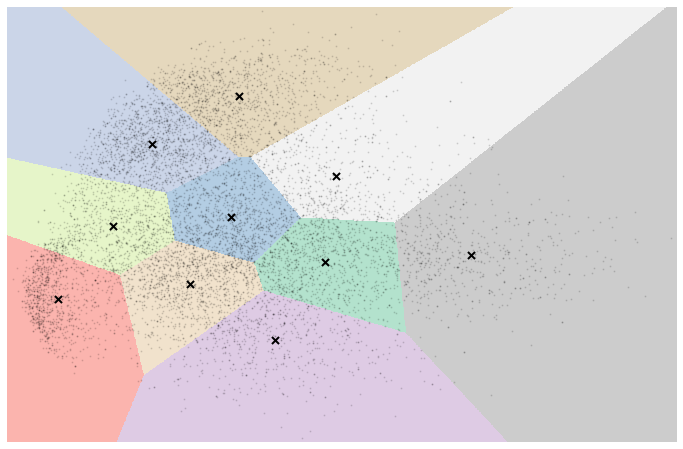

In [16]:
indices = np.random.randint(0, len(y_train), 10000)
sample_X = scaled_X[indices]
sample_y = y_train[indices]

plot_veronoi(sample_X, sample_y, kmeans)

From the voronoi plot we can see the decision boundaries for each of the clusters. It seems to have made out a few good clusters, notably the one to the left which has quite a dense clustering. The remaining datapoints are quite mixed so clustering hasn't performed that well, which is to be expected.

#### KMeans performance

We shall look at two metrics to get an idea of clustering performance, silhouette score and adjusted random score.

In [17]:
silhouette_score(X_train_2, kmeans.labels_)

0.35687908622295145

In [18]:
score = adjusted_rand_score(y_train, kmeans.labels_)
print(score)

0.23298782971390194


Firstly the silhouette score is a measure of the distance between points and the closest cluster. It is similar to intertia in this sense but it is more insightful as it is scaled in a way which results in a score of 1 being the optimal clustering solution and numbers above 0 being good clustering solutions. Negative numbers indicate poor clustering performance or an unconverged KMeans solution. Here we have a score of 0.36, which is good considering how mixed the classes are in 2 dimensions.

As for the adjusted random score, this attemps to measure the similarity between the real labels and the kmeans cluster labels. This similarity measure is used as KMeans is an unsupervised method and generates labels for data randomly. This results in labels not representing the class labels in the testing set so an accuracy measure cannot be made without mapping the cluster labels to the class labels. If this score is to be trusted, we have an accuracy of around 24% which is at least twice as good as guessing. This is likely down to the data being highly mixed in 2 dimensions - clustering on the t-SNE dimensionality reduction will likely give better results.

### Finding the optimal number of clusters

Although we know that the MNIST dataset consists of 10 classes it can be interesting to see how KMeans clustering performs with varying number of clusters.

In [ ]:
ks = range(20)
kmeans_k = [KMeans(n_clusters=k+1).fit(X_train_2) for k in ks]

In [ ]:
inertia_k = [km.inertia_ for km in kmeans_k]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("KMeans Cluster Count Affect on Inertia")
ax.set_xlabel("KMeans clusters")
ax.set_ylabel("Intertia")
ax.set_xticks(ks)
ax.plot(ks, inertia_k)
plt.show

In [ ]:
# silhouette_k = [silhouette_score(X_train_2, km.labels_) for km in kmeans_k]
print(kmeans_k[0].labels_.shape)
print(X_train_2.shape)
silhouette_sc = silhouette_score(X_train_2, kmeans_k[0].labels_)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("KMeans Cluster Count Affect on Silhouette Score")
ax.set_xlabel("KMeans clusters")
ax.set_ylabel("Silhouette score")
ax.set_xticks(ks)
ax.plot(ks, silhouette_k)
plt.show

### Clustering in high-dimensional space

To get better clustering results we can cluster in a higher dimension. I shall apply kmeans with various dimensions and use kmeans to cluster each result and compare performance.

In [ ]:
dimensions = np.logspace(0, 8, 9, base=2).astype('int') + 1
print(dimensions)

In [ ]:
X_train_d = [PCA(n_components=d).fit_transform(X_train) for d in dimensions]

Now we have the transformed data we can apply KMeans clustering to each space.

In [ ]:
kmeans_d = [KMeans(n_clusters=10).fit(X) for X in X_train_d]

Now we can calculate teh silhouette score to analyse clustering performance.

In [ ]:
silhouette_d = [silhouette_score(X, km.labels_) for (X, km) in zip(X_train_d, kmeans_d)]

In [ ]:
print(silhouette_d)

In [ ]:
scores_d = [adjusted_rand_score(y_train, km.labels_) for km in kmeans_d]

In [ ]:
print(scores_d)

In [ ]:
results = np.array([dimensions, silhouette_d, scores_d])
df = pd.DataFrame(results.T, columns=['Dimensions', 'Silhouette score', 'Adj.rand score'])
print(df)

fig1_df = df[['Dimensions', 'Silhouette score', 'Adj.rand score']]
fig1_df = pd.melt(fig1_df, ['Dimensions'], var_name="",
                  value_name="Score")

fig, ax = plt.subplots(figsize=(18, 8))
plt.subplot(121)
fig1 = sns.lineplot(data=fig1_df, x='Dimensions', y='Score', hue='')
fig1.set(xlim=[1, 250], ylim=[0.05, 0.45])
fig1.set_title("Affect of kmeans clustering in various dimensional space")

It is somewhat difficult to interpret results from KMeans clustering and unsupervised learning in general.

Using the silhouette score and likewise with intertia, we cannot make comparisons between models using different dimenions. This is due to the sparsity of high-dimension data.

Using the adjust random score metric we can compare the similarity of labels from kmeans and the real labels of the dataset. If this metric is to be trusted we can see increasing dimensions helps up until around 10 dimensions. Any further seems to not aid clustering performance although this could be an issue with the metric.

To analyse performance of the clustering we would need a way to map kmeans clustering labels to the real labels, but that is not really the aim of clustering as it is an unsupervised method.

### Limits of K-Means  

- Limits of KMeans

### Further analysis

To explore the data further I would apply additional clustering methods to try and improve my resutls. This could be fitting a mixture of gaussians to the data or clutering with Bayesian gaussian mixtures
- KMedian
- Analyse gaussian mixtures
- Bayesian gaussian mixtures
- DBScan?

## Data analysis conclusion

- Final analysis of MNIST dataset